<center><a href="https://wangyu16.github.io/PolymerScienceEducation/"><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/Fig/Logo_black.svg" width='150' /></a></center>

# Conventional Radical Polymerization

-----------

To learn the background knowledge, please visit this [study guide](https://hackmd.io/@YW2025/rJUFjZAnR).

##  What does this simulator do and how to use it?

The simulator provides kinetic reaction results of conventional radical polymerization. Users simply select the initial conditions and run the simulation. The results will be shown below.

## 1. Import packages and set the values of parameters

In [1]:
#@title { display-mode: "form" }

%%capture
import sys
if not 'chempy' in sys.modules:
    !pip install chempy
from chempy import ReactionSystem, Substance
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12}) # Feel free to change the font size in the plots.
from ipywidgets import interact
import datetime
import csv

density = {'St': 0.909, 'MMA':0.940, 'MA':0.950, 'VAc':0.934, 'AN':0.810} # g/mL
molar_mass ={'St': 104.15, 'MMA': 100.12, 'MA':86.09, 'VAc':86.09, 'AN':53.06} # g/mol

# Propagation rate coefficients of monomers.
# For AN, 'Determination of the propagation rate coefficient of acrylonitrile' Polym. Chem., 2010,1, 438-441, DOI: 10.1039/C0PY00019A
# For the rest, "Rate coefficients of free-radical polymerization deduced from pulsed laser experiments" Prog. Polym. Sci., 2002, 27, 191-254, DOI: 10.1016/S0079-6700(01)00049-1
kp_Ea = {'St':31.5, 'MMA': 22.4, 'MA': 17.7, 'VAc': 20.7, 'AN': 14.4} # kJ/mol
kp_A = {'St':2.88e7, 'MMA':2.67e6, 'MA':1.66e7, 'VAc':1.47e7, 'AN': 1.79e6} # /mol.s

# Decomposition rate coefficients of initiators.
# For AIBN, ACHN, VR-110, "A Critical Assessment of the Kinetics and Mechanism of Initiation of Radical Polymerization with Commercially Available Dialkyldiazene Initiators" Prog. Polym. Sci. 2019, 88, 130-188, DOI: 10.1016/j.progpolymsci.2018.08.003
# For BPO, it is calculated from Sigma Aldrich "Applications: Free Radical Initiators"
kd_Ea = {'AIBN':131, 'BPO': 141, 'ACHN': 150, 'VR-110': 147}
kd_A = {'AIBN':3.2e15, 'BPO': 3.4e16, 'ACHN': 7.9e16, 'VR-110': 2.0e15}

## 2. Reaction conditions

Compounds used in this simulator:

<center><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/OVESET/img/radicalpolymerizationkinetics.svg" width='450'/></center>

In [2]:
#@title { display-mode: "form" }
Poly_type = "conven"

#@markdown ### Choose the monomer and set the volume fraction of the monomer
#@markdown **St**: styrene; **MMA**: methyl methacrylate; **MA**: methyl acrylate; **VAc**: vinyl acetate; **AN**: acrylonitrile
Monomer = "St" #@param ["St", "MMA", "MA", "VAc", "AN"]
Fraction_of_Monomer = 0.33 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown Suppose you want to do bulk polymerization, you can set the fraction as 1. If you want to do a solution polymerization with half monomer and half solvent by volume, then set the fraction as 0.5. Solvent effect on reaction rate is not taken into account, thus there is no need to select a specific solvent for the simulation.

#@markdown ### Choose the thermal initiator (TI) and set the concentration (mol/L)
#@markdown **AIBN**: azobis(isobutyronitrile); **BPO**: benzoyl peroxide; **ACHN**: 1,1’-azobis-(1-cyclohexanenitrile); **VR-110**: 2,2'-Azobis(2,4,4-trimethylpentane)
TI = "AIBN" #@param ["AIBN", "BPO", "ACHN", "VR-110"]
c0_TI = 0.01 #@param {type:"slider", min:0, max:0.1, step:0.0001}

#@markdown ### Select the reaction temperature ($^\circ$C) and reaction time (h)
Temperature = 60 #@param {type:"slider", min:0, max:130, step:1}
Temperature = Temperature + 273.15
react_time = 24 #@param {type:"slider", min:0, max:72, step:0.1}
react_time = react_time*3600
#@markdown Be careful of the bolling temperatures of the monomers (styrene 145 $^\circ$C, MMA 101 $^\circ$C, MA 80 $^\circ$C, VAc 72 $^\circ$C, AN 77$^\circ$C). Choosing a temperature above the boiling point may cause problems in the real world experiments.

# Rate coefficient of decomposition of the initiator
k_d_TI = kd_A[TI]*np.exp(-kd_Ea[TI]*1000/8.314/Temperature)
# Initiation efficiency
f_TI = 0.8
# Propagation rate coefficient
k_p = kp_A[Monomer]*np.exp(-kp_Ea[Monomer]*1000/8.314/Temperature)
# Initial monomer concentration
c0_M = density[Monomer]*1000/molar_mass[Monomer]*Fraction_of_Monomer
MM = molar_mass[Monomer]
# Rate coefficient of termination between propagating chains
k_tc = 5e7 # Termination by coupling
k_td = 5e7 # Termination by disproportionation
# Self initiation of the monomer, only styrene needs to be considered.
if Monomer == "styrene":
  k_th_S = 2.2e5*np.exp(-13810/Temperature)
else:
  k_th_S = 0
# Set the rate coefficients for the addition of the first monomer to the primary radical;
k_p_R = k_p
# the termination between primary radicals; the termination between a primary radical and a propagating radical.
k_t_R = 2.5e9
k_t_R_Pn = 1e8


In [3]:
#@title Construct the reaction system { display-mode: "form" }
# Initiate the reaction system with null value.
# The rsys_orig is the system of the actual reactions.
# The rsys_pseudo includes the pseudo reactions with pseudo species
# which are used to introduce 1st and 2nd order moments
# and to adjust the reactions to take into account the initiation efficiency, etc.
rsys_orig = ReactionSystem.from_string("""
    """, substance_factory=Substance)
rsys_pseudo =  ReactionSystem.from_string("""
    """, substance_factory=Substance)

# Initial concentrations of monomer, dead chains, radicals, and pseudo species of moments.
c0 = defaultdict(float, {'M': c0_M, 'D': 0, 'PnD': 0, 'PnDPn': 0, 'R': 0, 'Pn': 0, 'M1_Pn': 0, \
                         'M1_PnD': 0, 'M1_PnDPn': 0, 'M2_total': 0})

# Add propagation and termination reactions to the reaction system.
rsys_orig += ReactionSystem.from_string(f"""
    R + M -> Pn; {k_p_R}
    Pn + M -> Pn; {k_p}
    R + R -> D + D; {k_t_R}
    Pn + R -> PnD + D; {k_t_R_Pn}
    Pn + Pn -> PnD + PnD; {k_td}
    Pn + Pn -> PnDPn; {k_tc}
    """, substance_factory=Substance)
rsys_pseudo += ReactionSystem.from_string(f"""
    R + M -> R + M + M1_Pn + M2_total; {k_p_R}
    Pn + M -> Pn + M + M1_Pn + M2_total; {k_p}
    M1_Pn + M -> M1_Pn + M + M2_total; {2*k_p}
    M1_Pn + R -> M1_PnD + R; {k_t_R_Pn}
    M1_Pn + Pn -> M1_PnD + Pn; {2*k_td}
    M1_Pn + Pn -> M1_PnDPn + Pn; {2*k_tc}
    M1_Pn + M1_Pn -> M1_Pn + M1_Pn + M2_total; {2*k_tc}
    """, substance_factory=Substance)

# To include the thermal initiaion for styrenic monomers
if k_th_S != 0:
    rsys_orig += ReactionSystem.from_string(f"""
        M + M + M -> R + R; {k_th_S}
        """, substance_factory=Substance)


# The thermal initiator is consumed with a rate coefficient k_d_TI;
# however, not all of the primary radicals would involve in propagation.
# To take into account the initiation efficiency, pseudo reactions and a pseudo species 'PR' are introduced.

c0.update({'TI': c0_TI, 'PR': 0})
rsys_orig += ReactionSystem.from_string(f"""
    TI -> R + R; {k_d_TI}
    """, substance_factory=Substance)
rsys_pseudo += ReactionSystem.from_string(f"""
    TI -> R + R; {-k_d_TI}
    TI -> PR + PR; {k_d_TI}
    TI -> TI + R + R; {f_TI*k_d_TI}
    """, substance_factory=Substance)

# List the initial concentrations of reagents
print("The reagents and their concentrations (mol/L) are as follows:")
for key in c0:
    if c0[key] != 0:
        print(key, ': ', c0[key])
print("where 'M' means the monomer, 'TI' means the thermal initiator.")
# Show the reactions and the rate coefficients in the system
print("The reactions involved are listed below with their rate coefficients.")
rsys_orig

The reagents and their concentrations (mol/L) are as follows:
M :  2.8801728276524243
TI :  0.01
where 'M' means the monomer, 'TI' means the thermal initiator.
The reactions involved are listed below with their rate coefficients.


## 3. Simulation

**List of the differential equations**

In [4]:
#@title { display-mode: "form" }
# Combine the actual and the pseudo reaction systems
rsys = rsys_orig + rsys_pseudo

# Get the differential equation system from the reactions.
odesys, extra = get_odesys(rsys)

# List the differential equations
for index, exp in enumerate(odesys.exprs):
    if odesys.names[index] != 'PR':
        print(odesys.names[index], ': ', f'dy_{index}/dt', '= ',  exp)

D :  dy_0/dt =  100000000.0*y_2*y_5 + 5000000000.0*y_5**2
M :  dy_1/dt =  -331.37843254586*y_1*y_2 - 331.37843254586*y_1*y_5
Pn :  dy_2/dt =  331.37843254586*y_1*y_5 - 200000000.0*y_2**2 - 100000000.0*y_2*y_5
PnD :  dy_3/dt =  100000000.0*y_2**2 + 100000000.0*y_2*y_5
PnDPn :  dy_4/dt =  50000000.0*y_2**2
R :  dy_5/dt =  -331.37843254586*y_1*y_5 - 100000000.0*y_2*y_5 - 5000000000.0*y_5**2 + 1.47576729074005e-5*y_6
TI :  dy_6/dt =  -9.22354556712529e-6*y_6
M1_Pn :  dy_7/dt =  331.37843254586*y_1*y_2 + 331.37843254586*y_1*y_5 - 200000000.0*y_2*y_7 - 100000000.0*y_5*y_7
M1_PnD :  dy_8/dt =  100000000.0*y_2*y_7 + 100000000.0*y_5*y_7
M1_PnDPn :  dy_9/dt =  100000000.0*y_2*y_7
M2_total :  dy_10/dt =  331.37843254586*y_1*y_2 + 331.37843254586*y_1*y_5 + 662.756865091719*y_1*y_7 + 100000000.0*y_7**2


The differential equation system includes not only the real species, i.e., those taht appear in the actual reactions, but also the pseudo species, e.g., the 1st and 2nd order moments.

In [5]:
#@title { display-mode: "form" }
%%time

# Integration
tout = sorted(np.concatenate((np.linspace(0, react_time), np.logspace(0, np.floor(np.log10(react_time))))))
result = odesys.integrate(tout, c0, integrator='scipy', method='lsoda', atol=1e-12, rtol=1e-6)

CPU times: user 168 ms, sys: 14.5 ms, total: 182 ms
Wall time: 357 ms


## 4. Results

### Concentration changes

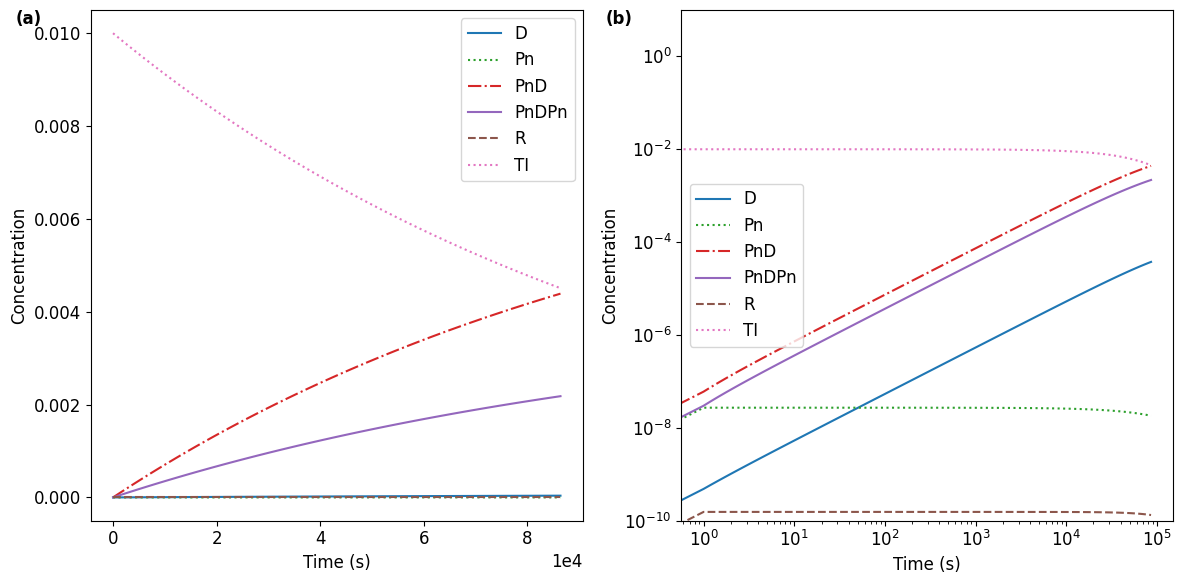

In [6]:
#@title { display-mode: "form" }
# Plot the concentrations of species in the reaction system vs time.
# The change of monomer concentration is not included here since monomer conversion will be plotted later.
labels=['(a)','(b)','(c)']
i=0
fig1, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax in axes:
     _ = result.plot(names=[k for k in rsys_orig.substances if k != 'CuIsour' \
                            and k != 'M' and k!= 'elec' and k != 'Cu0'], ax=ax)
     _ = ax.legend(loc='best',prop={'size': 12}) # Set the font size of the legend here.
     _ = ax.set_xlabel('Time (s)')
     _ = ax.set_ylabel('Concentration')
     _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
     i+=1
axes[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
_ = axes[1].set_ylim([1e-10, 1e1])
_ = axes[1].set_xscale('log')
_ = axes[1].set_yscale('log')
_ = fig1.tight_layout()

#### Meanings of the species produced during the polymerization

R: primary radical either from the thermal initiator  
D: termination product from primary radicals  
Pn: propagating polymer chain with a chain end radical  
PnD: dead polymer chain produced by termination through disproportionation  
PnDPn: dead polymer chain produced by termination through coupling

**Note**: The choice of monomer affects the relative reaction rates of termination by coupling and disproportionation. Additionally, the rate coefficients of termination change with chain length and viscosity. Considering all these factors can be very complicated. To keep things simple for educational purposes, this simulator sets the rate coefficients of termination as constants.

### Monomer conversion vs time

In [7]:
#@title { display-mode: "form" }
# Get concentrations and calculate conversion, Mn and Mw/Mn.
ConcM = result[1][:,result.odesys.names.index('M')]
ConcD = result[1][:,result.odesys.names.index('D')]
ConcPnD = result[1][:,result.odesys.names.index('PnD')]
ConcPnDPn = result[1][:,result.odesys.names.index('PnDPn')]
ConcPn = result[1][:,result.odesys.names.index('Pn')]
ConcM2_total = result[1][:,result.odesys.names.index('M2_total')]

ConvM =(ConcM[0]-ConcM)/ConcM[0]
LnM0_M = np.log(ConcM[0]/ConcM)

Mn = np.zeros(len(result[0]))
Mw = np.zeros(len(result[0]))
Mw_Mn = np.ones(len(result[0]))

Mn[1:] = (ConcM[0]-ConcM[1:])/(ConcPnD[1:] + ConcPnDPn[1:] + ConcPn[1:])*MM
Mw[1:] = ConcM2_total[1:]/(ConcM[0]-ConcM[1:])*MM
Mw_Mn[1:] = Mw[1:]/Mn[1:]


result_cal = [result[0],ConcM,ConvM,LnM0_M,Mn,Mw_Mn]

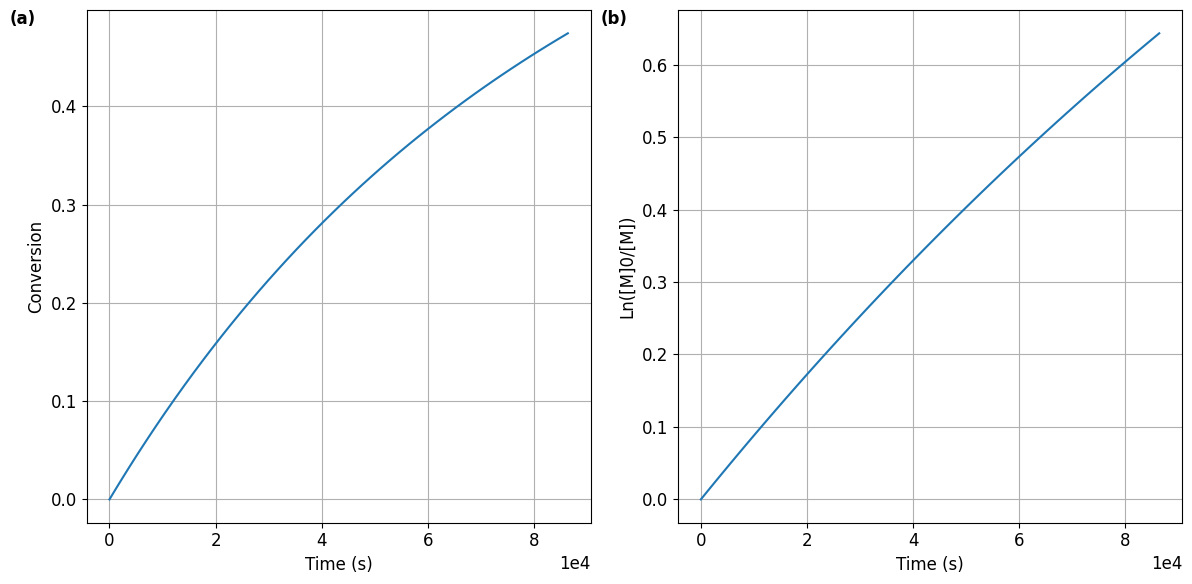

In [8]:
#@title { display-mode: "form" }
# Monomer conversion vs. time and first order kinetic plots.
fig2, axes = plt.subplots(1, 2, figsize=(12, 6))
i=0
for ax in axes:
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    _ = ax.plot(result_cal[0], result_cal[i+2])
    _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'Time (s)', ylabel='Conversion')
_ = axes[1].set(xlabel = 'Time (s)', ylabel='Ln([M]0/[M])')
_ = fig2.tight_layout()

### Molecular weight and molecular weight distribution.

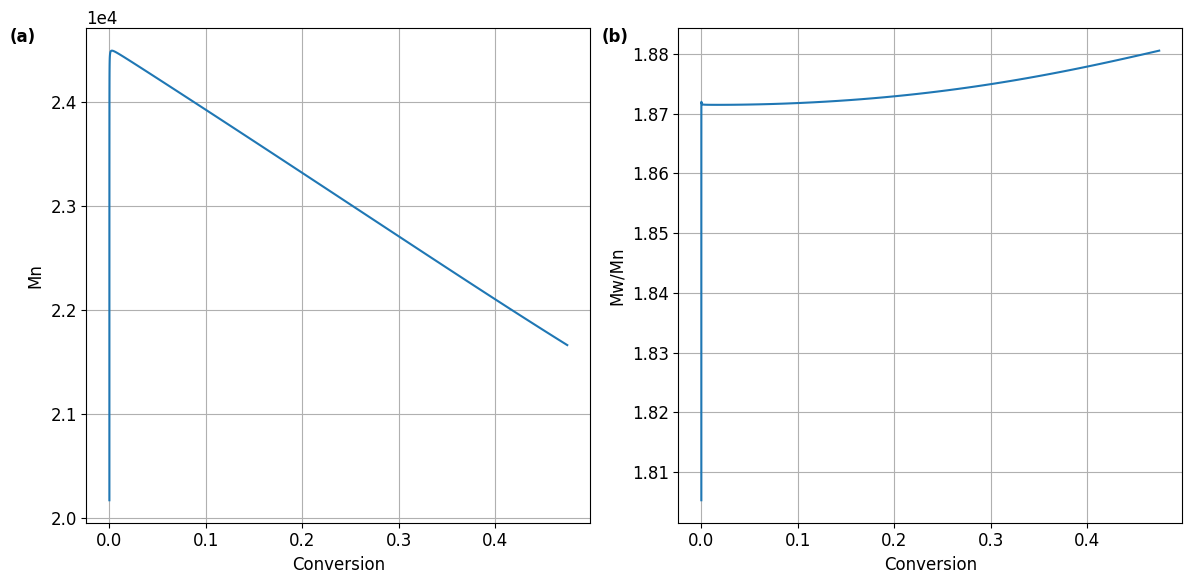

In [9]:
#@title { display-mode: "form" }
# Plot Mn, Mw/Mn and Tmol% vs. conversion.
fig3, axes = plt.subplots(1, 2, figsize=(12, 6))
i=0
for ax in axes:
    _ = ax.plot(result_cal[2][1:], result_cal[i+4][1:])
    _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'Conversion', ylabel='Mn')
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
_ = axes[1].set(xlabel = 'Conversion', ylabel='Mw/Mn')
_ = fig3.tight_layout()




---



In [1]:
#@title Copyright { display-mode: "form" }
import requests
from IPython.display import Markdown
copyright = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/copyright.md")
Markdown(copyright.text)

---

### MIT License  

Copyright (c) 2021 -- 2024 Yu Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Contact

Dr. Yu Wang  
Department of Chemistry  
Institute for Materials Research and Innovation  
University of Louisiana at Lafayette  
Lafayette, LA 70504  
Email: yuwang@louisiana.edu

### Acknowledgement

This project is sponsored by National Science Foundation (NSF-2142043). 


In [2]:
# @title {display-mode: "form" }
links = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/links.md")
Markdown(links.text)

---

### Links

**[Home page of OVESET](https://wangyu16.github.io/PolymerScienceEducation/):** 

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_OVESET.svg" alt="OVESET Home Page" width="300">

**[Home page of Study Guide](https://hackmd.io/@YW2025/HJLiqoHRR)**

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_PolymerStudyGuide.svg" alt="Introduction to Polymer Science" width="300">

